# Introduction

Goal: We will study Bayesian inference for ordinary differential equations (ODEs) under model misspecification, in particular looking at how the predictive performance, posterior geometry, and parameter identifiability are affected when the assumed dynamical model used to fit the data differs from the true data-generating mechanism. We will run simulations to explore how structural misspecification impacts inference in several canonical systems of differential equations: the Lotka–Volterra system and the SIR model. By simulating data from these "true" ODE systems then fitting misspecified Bayesian models, we will assess how inference deteriorates using performance diagnostics such as entropy, posterior predictive checks, calibration, and coverage. This work will explore the connection between theory of ill-posed inverse problems and Bayesian modeling practice for deterministic real-world systems.


In [358]:
# Import required packages and modules
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pytensor
import pytensor.tensor as pt

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import least_squares

In [359]:
# Set global configurations for this notebooks, mostly plot settings
# %load_ext watermark
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(84)

In [360]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.27.0


# Background

## Lotka–Volterra Model

The Lotka–Volterra model is a famous model describing the population dynamics between prey and predators in a population, given by the differential equations:
$$
\frac{dx}{dt} = \alpha x - \beta xy
$$
$$
\frac{dy}{dt} = -\gamma y + \delta xy,
$$
where
- $\alpha$: the prey growth rate when there are no predators
- $\beta$: the death rate of prey in the presence of predation
- $\gamma$: the death rate of predators when there are no prey
- $\delta$: the predator growth rate in the presence of prey

In an inverse problem, our goal is to estimate, under uncertainty, the parameters $\theta = (\alpha, \beta, \gamma, \delta)$ of this model using Bayesian inference.

The Lotka–Volterra model is notable for its parsimoniousness and ability to capture the exchanging dynamics between the two populations in simple settings; for example, this model fits quite well to the classic Hudson's Bay dataset on the populations of hares and lynx between 1900 and 1920. However, in more complex, real-world settings with other forces at play, the model becomes limited due to its naive assumptions

- Unrealistic Assumptions: It assumes predators only eat one type of prey, prey have an unlimited food supply, and there is no environmental complexity.
- Neutrally Stable Cycles: The basic model produces oscillations with a fixed amplitude that depend entirely on initial conditions, rather than returning to a stable equilibrium.
- No Density Dependence: It often ignores factors like carrying capacity, which leads to unrealistic, perpetual oscillations.

In [361]:
# Implement Lotka–Volterra model
def lotka_volterra(x, y, alpha, beta, gamma, delta):
    dx_dt = alpha * x - beta * x * y
    dy_dt = -gamma * y + delta * x * y
    return [dx_dt, dy_dt]

In [362]:
lotka_volterra(0.1, 0.1, 1, 0.1, 1.5, 0.075)

[0.099, -0.14925000000000002]

Unfortunately, the SciPy and PyMC packages which we will be using throughout the analysis each "hard-code" different expectations for the function signature of the ODE. To address this conflict, we create two wrapper functions so that we may call the appropriate version for any particular use case at hand.

In [363]:
def lotka_volterra_scipy(t, y, p):    # Important: SciPy expects this exact signature (t, y, p)
    x_pop, y_pop = y
    alpha, beta, gamma, delta = p
    return lotka_volterra(x_pop, y_pop, alpha, beta, gamma, delta)

In [364]:
def lotka_volterra_odeint(y, t, p):
    x_pop, y_pop = y
    alpha, beta, gamma, delta = p
    return lotka_volterra(x_pop, y_pop, alpha, beta, gamma, delta)

In [365]:
def lotka_volterra_pymc(y, t, p):    # Important: PyMC—specifically the DifferentialEquation module—expects this exact signature (y, t, p)
    x_pop = y[0]
    y_pop = y[1]

    alpha = p[0]
    beta  = p[1]
    gamma = p[2]
    delta = p[3]

    dxdt = alpha * x_pop - beta * x_pop * y_pop
    dydt = delta * x_pop * y_pop - gamma * y_pop

    return [dxdt, dydt]

In [366]:
# Plot level sets of Lotka–Volterra model
# Hudson Bay Company least-squares parameters: array([4.810e-01, 2.500e-02, 9.260e-01, 2.800e-02, 3.491e+01, 3.860e+00])
# Parameters
alpha = 0.481
beta  = 0.025
gamma = 0.926
delta = 0.028
theta = np.array([alpha, beta, gamma, delta])

/var/folders/k1/bz3mf5t15h96yvggnqmy2bj40000gn/T/ipykernel_10751/4160936452.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


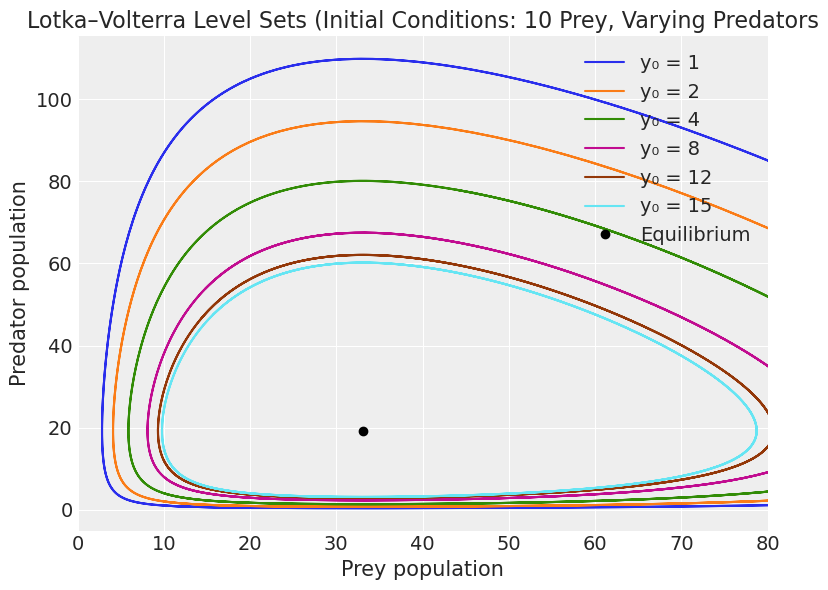

In [367]:
t_span = (0, 30)
t_eval = np.linspace(*t_span, 1000)

# Initial conditions
x0 = 10.0
predator_initials = [1, 2, 4, 8, 12, 15]

plt.figure(figsize=(8, 6))

for y0 in predator_initials:
    sol = solve_ivp(
        lotka_volterra_scipy,    # Use the SciPy version of the ODE model implementation for plotting
        t_span,
        [x0, y0],
        args=(theta,),
        t_eval=t_eval,
        rtol=1e-9,
        atol=1e-12
    )
    # Add level set
    plt.plot(sol.y[0], sol.y[1], label=f"y₀ = {y0}")

# Plot equilibrium point
plt.plot(gamma / delta, alpha / beta, 'ko', label="Equilibrium")

plt.xlabel("Prey population")
plt.ylabel("Predator population")
plt.xlim([0, 80])
plt.title("Lotka–Volterra Level Sets (Initial Conditions: 10 Prey, Varying Predators")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save for download
plt.savefig("../figures/lotka_volterra_level_sets.png", dpi=300)
plt.show()


# Analysis

## Baseline Inference Procedure

In [368]:
# ODE model
lv_ode = pm.ode.DifferentialEquation(
    func=lotka_volterra_pymc,
    times=data.time.values,
    n_states=2,
    n_theta=4,
    t0=data.time.values[0],
)

In [369]:
# Data generating process
def simulate_lv_data_pymc(theta, y_init):
    theta = np.asarray(theta, dtype=float)
    y_init = np.asarray(y_init, dtype=float)

    sol = lv_ode(y0=y_init, theta=theta)

    # compile small function to evaluate
    f = pytensor.function([], sol)

    return f()

In [370]:
# Define initial conditions
y_init = np.array([30., 4.])

# Define time grid/timescale
t_obs = np.arange(0., 29.1, 1)

In [371]:
# Generate data
y = simulate_lv_data_pymc(theta, y_init)

In [372]:
sigma_x = 1    # noise
sigma_y = 1

# Observation model
x_obs = y[:, 0] + rng.normal(0, sigma_x, size=len(t_obs))
y_obs = y[:, 1] + rng.normal(0, sigma_y, size=len(t_obs))

# enforce positivity (important for LV)
x_obs = np.clip(x_obs, 1e-3, None)
y_obs = np.clip(y_obs, 1e-3, None)

In [373]:
# fmt: off
data = pd.DataFrame(dict(
    time = t_obs,
    prey = np.round(x_obs, 2),
    predator = np.round(y_obs, 2)
))
data.head()
# fmt: on

,time,prey,predator
0,0.0,28.45,4.27
1,1.0,43.48,4.74
2,2.0,59.25,7.46
3,3.0,73.57,20.75
4,4.0,48.02,49.52


In [374]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="Simulated Lotka–Volterra Data"):
    ax.plot(data.time, data.prey, color="b", lw=lw, marker="o", markersize=12, label="Prey (Data)")
    ax.plot(data.time, data.predator, color="r", lw=lw, marker="+", markersize=14, label="Predator (Data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([0, 30])
    ax.set_ylim(0)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Population", fontsize=14)
    ax.set_xticks(data.time.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=16)

    plt.savefig("../figures/lotka_volterra_simulated_data.png", dpi=300)
    return ax

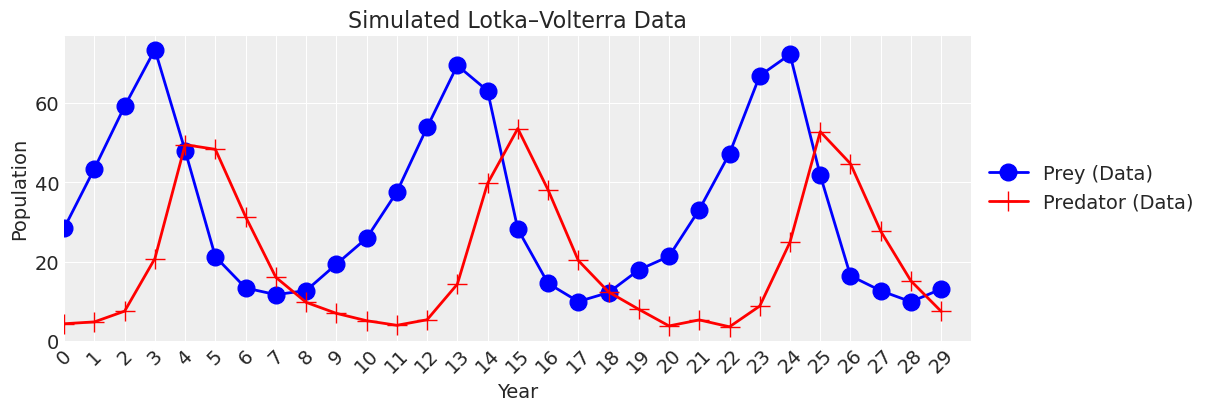

In [375]:
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax);

In [397]:
# Implement the Bayesian inference procedure in a PyMC Model
with pm.Model() as lv_model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=0.481, sigma=0.1, lower=0, initval=0.481)    # Can use least-squares solutions for prior means as well...
    beta = pm.TruncatedNormal("beta", mu=0.025, sigma=0.01, lower=0, initval=0.025)
    gamma = pm.TruncatedNormal("gamma", mu=0.926, sigma=0.1, lower=0, initval=0.926)
    delta = pm.TruncatedNormal("delta", mu=0.028, sigma=0.01, lower=0, initval=0.028)

    # xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    # yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])

    theta = pt.stack([alpha, beta, gamma, delta])
    
    # Initial conditions/populations
    x_0 = 30
    y_0 = 4

    y_init = np.array([x_0, y_0], dtype=float)
    # y_init = [xt0, yt0]

    y_hat = lv_ode(y0=y_init, theta=theta)
    
    # Likelihood (observation model)
    # sigma = 1    # fix for experimental control
    sigma = pm.HalfNormal("sigma", 10)
    # sigma = pm.Exponential("sigma", 1, shape=2)

    pm.Normal("obs", mu=y_hat, sigma=sigma, observed=data[["prey", "predator"]].values)


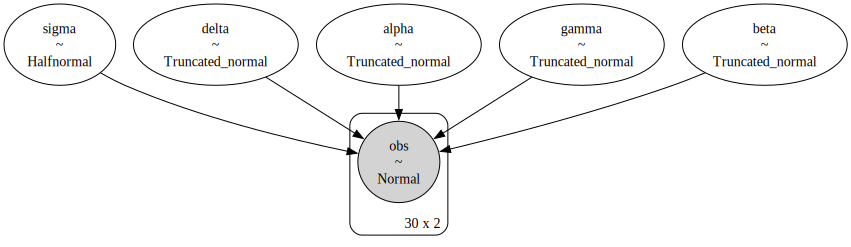

In [398]:
pm.model_to_graphviz(model=lv_model)

In [399]:
# Note: pymc.ode is quite slow! We only do a relatively small number of runs for now
with lv_model:
    trace_pymc_ode = pm.sample(draws=15, tune=15, chains=4, target_accept=0.9,)

Only 15 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta, sigma]


Output()

Sampling 4 chains for 15 tune and 15 draw iterations (60 + 60 draws total) took 154 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


In [400]:
trace = trace_pymc_ode
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.424,0.160,0.142,0.634,0.060,0.033,8.0,16.0,3.23
beta,0.025,0.009,0.012,0.045,0.003,0.003,8.0,20.0,2.86
gamma,0.869,0.083,0.712,0.989,0.024,0.013,12.0,43.0,1.53
delta,0.027,0.006,0.011,0.035,0.002,0.002,10.0,16.0,2.05
sigma,12.239,11.417,3.316,43.978,4.076,3.441,8.0,20.0,3.19


In [401]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=np.arange(0, 29, 0.01),
    alpha=1,
    lw=3,
    title="Hudson's Bay Company Data and\nExample Model Run",
):
    ax.plot(time, x_y[:, 1], color="r", alpha=alpha, lw=lw, label="Lynx (Model)")
    ax.plot(time, x_y[:, 0], color="b", alpha=alpha, lw=lw, label="Hare (Model)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax

In [402]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["alpha", "beta", "gamma", "delta"]
    row = trace_df.iloc[row_idx, :][cols].values

    # alpha, beta, gamma, delta, Xt0, Yt0
    time = np.arange(0, 29, 0.01)
    theta = row
    # x_y = simulate_lv_data_pymc(theta, y_init)
    x_y = odeint(func=lotka_volterra_odeint, y0=np.array([x_0, y_0], dtype=float), t=time, args=(theta,))
    
    plot_model(ax, x_y, lw=lw, alpha=alpha);

In [403]:
def plot_inference(
    ax,
    trace,
    num_samples=25,
    title="Hudson's Bay Company Data and\nInference Model Runs",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

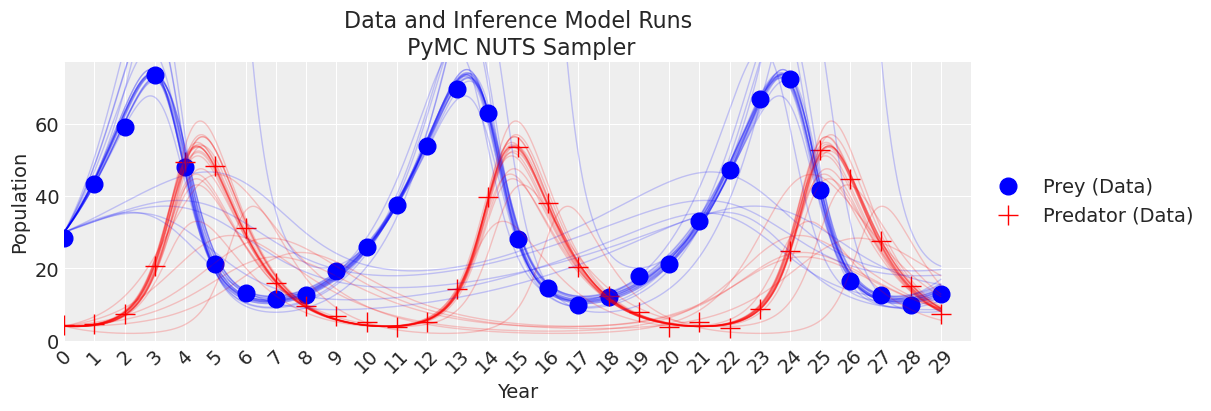

In [404]:
_, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n PyMC NUTS Sampler");

## Model Misspecification

$$
\frac{dx}{dt} = \alpha x - \frac{\beta xy}{1+hx}
$$
$$
\frac{dy}{dt} = -\gamma y + \frac{\delta xy}{1+hx},
$$
where $h$ is the saturated (Holling type II) functional response parameter that defines the structural misspecification in the model. When $h = 0$, we recover the standard Lotka–Volterra equations.

Our true data will be generated from the above system, but we assume, incorrrectly, that we can fit the standard Lotka–Volterra model (i.e., $h = 0$ above) to the data. This defines our structural misspecification for this study.

In [384]:
# Implement altered Lotka–Volterra model
def lotka_volterra_saturated(x, y, alpha, beta, gamma, delta):
    dx_dt = alpha * x - ((beta * x * y) / (1+hx))
    dy_dt = -gamma * y + ((delta * x * y) / (1+hx))
    return [dx_dt, dy_dt]

In [385]:
def lotka_volterra_scipy_saturated(t, y, p):    # Important: SciPy expects this exact signature (t, y, p)
    x_pop, y_pop = y
    alpha, beta, gamma, delta = p
    return lotka_volterra(x_pop, y_pop, alpha, beta, gamma, delta)

In [386]:
def lotka_volterra_pymc_saturated(y, t, p):    # Important: PyMC—specifically the DifferentialEquation module—expects this exact signature (y, t, p)
    x_pop = y[0]
    y_pop = y[1]

    alpha = p[0]
    beta  = p[1]
    gamma = p[2]
    delta = p[3]

    dxdt = alpha * x_pop - ((beta * x_pop * y) / (1+hx))
    dydt = delta * x_pop * y_pop - ((delta * x_pop * y) / (1+hx))

    return [dxdt, dydt]

In [387]:
# Data generating process
def simulate_lv_data_saturated(theta, y_init, t_obs, rtol=1e-9, atol=1e-12):
    sol = solve_ivp(
        lotka_volterra_scipy_saturated,
        t_span=(t_obs[0], t_obs[-1]),
        y0=y_init,
        t_eval=t_obs,
        args=(theta, ),
        rtol=rtol,
        atol=atol
    )
    return sol.y.T    # Shape (len(t_obs), 2)

In [388]:
# Generate data
y = simulate_lv_data_saturated(theta, y_init, t_obs)
y_obs = y * np.exp(rng.normal(0, sigma, size=y.shape))

ValueError: setting an array element with a sequence.

In [ ]:
# fmt: off
data_saturated = pd.DataFrame(dict(
    time = t_obs,
    prey = np.round(y[:, 0], 2),
    predator = np.round(y[:, 1], 2)
))
data_saturated.head()
# fmt: on

In [ ]:
# Plot new data along with the original, correct data
# plot data function for reuse later
def plot_data_saturated(ax, lw=2, title="Simulated Lotka–Volterra Data"):
    ax.plot(data_saturated.time, data_saturated.prey, color="b", lw=lw, marker="o", markersize=12, label="Prey (Data)")
    ax.plot(data_saturated.time, data_saturated.predator, color="r", lw=lw, marker="+", markersize=14, label="Predator (Data)")
    ax.plot(data.time, data.prey, color="b", lw=lw, linestyle="dashed", marker="o", markersize=12, label="Prey (Data)")
    ax.plot(data.time, data.predator, color="r", lw=lw, linestyle="dashed", marker="+", markersize=14, label="Predator (Data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([0, 30])
    ax.set_ylim(0)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Population", fontsize=14)
    ax.set_xticks(data_saturated.time.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=16)

    plt.savefig("../figures/lotka_volterra_saturated_simulated_data.png", dpi=300)
    return ax


In [ ]:
_, ax = plt.subplots(figsize=(12, 4))
plot_data_saturated(ax);

In [ ]:
# Implement the PyMC Model for the misspecified case
with pm.Model() as lv_model_saturated:
    # Priors
    alpha = pm.LogNormal("alpha", mu=np.log(1), sigma=0.1)    # Can use least-squares solutions for prior means as well...
    beta = pm.LogNormal("beta", mu=np.log(0.1), sigma=0.01)
    gamma = pm.LogNormal("gamma", mu=np.log(1.5), sigma=0.1)
    delta = pm.LogNormal("delta", mu=np.log(0.075), sigma=0.01)

    theta = pm.math.stack([alpha, beta, gamma, delta])
    
    # Initial conditions/populations
    x_0 = 40
    y_0 = 10

    y_init = np.array([x_0, y_0], dtype=float)
    
    # ODE model
    lv_ode = pm.ode.DifferentialEquation(
        func=lotka_volterra_pymc,
        times=data.time.values,
        n_states=2,
        n_theta=4,
        t0=data.time.values[0]
    )

    y_hat = lv_ode(y0=y_init, theta=theta)
    
    # Likelihood (observation model)
    sigma = 0.5    # fix for experimental control
    sigma = pm.Exponential("sigma", 10, shape=2)

    pm.LogNormal("obs", mu=pm.math.log(y_hat), sigma=sigma, observed=data[["prey", "predator"]].values)


In [ ]:
# Note: pymc.ode is quite slow!
with lv_model_saturated:
    trace_pymc_ode_saturated = pm.sample(draws=50, tune=50, chains=4, target_accept=0.9, max_treedepth=15,)

# Results + Discussion

# Conclusion